In [1]:
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mplib
from sklearn.decomposition import PCA
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import glob
import soundfile as sf
%matplotlib inline

# Set general font size
plt.rcParams['font.size'] = '14'

import warnings
warnings.filterwarnings("ignore")

# File Selection and equilizer


## 1. Select bird species based on species with most recordings in Michigan

In [2]:
features = pd.read_csv('features.csv', header=None, encoding='latin')
features.columns= ['id', 'gen', 'sp', 'ssp', 'en', 'cnt', 'loc', 'type', 'q', 'length', 'bird-seen', 'file']
features.head()

id          gen          sp  ssp                            en  \
0  527379  Dendrocygna  autumnalis  NaN  Black-bellied Whistling Duck   
1  480387  Dendrocygna  autumnalis  NaN  Black-bellied Whistling Duck   
2  316537  Dendrocygna  autumnalis  NaN  Black-bellied Whistling Duck   
3  192058  Dendrocygna  autumnalis  NaN  Black-bellied Whistling Duck   
4  172910  Dendrocygna  autumnalis  NaN  Black-bellied Whistling Duck   

             cnt                                                loc  \
0  United States  Circle B Bar Reserve, Lakeland, Polk County, F...   
1  United States                  Savannah, Chatham County, Georgia   
2  United States           Chalkley Road, Cameron Parish, Louisiana   
3  United States  Orlando Wetlands, Christmas, Orange County, Fl...   
4  United States  Orlando Wetlands, Christmas, Orange County, Fl...   

          type         q length bird-seen  \
0         call  no score   0:35       yes   
1         call         A   0:35       yes   
2         call         A   0:07       yes   
3  flight call         A   0:19       yes   
4         call         A   1:18       yes   

                                   file  
0  //www.xeno-canto.org/527379/download  
1  //www.xeno-canto.org/480387/download  
2  //www.xeno-canto.org/316537/download  
3  //www.xeno-canto.org/192058/download  
4  //www.xeno-canto.org/172910/download

In [3]:
# top_5 = list(features[features['loc'].str.lower().str.contains('michigan')].groupby('en')['id'].count().reset_index().sort_values(by='id', ascending=False)['en'][:5].values)
top_5_mich = ["Kirtland's Warbler", 'Common Yellowthroat', 'Red-winged Blackbird', 'Grey Catbird', 'American Redstart']

In [4]:
# features[features.en.isin(top_5)].groupby('en')['id'].count()
top_5 = list(features.groupby('en')['id'].count().reset_index().sort_values(by='id', ascending=False)['en'][:20].values)
features[features.en.isin(top_5)]['en'].value_counts()

Identity unknown           891
Song Sparrow               676
Spotted Towhee             506
Bewick's Wren              459
Red-winged Blackbird       436
Northern Cardinal          434
American Robin             421
Carolina Wren              402
House Wren                 394
Red Crossbill              384
Common Yellowthroat        354
Dark-eyed Junco            329
White-crowned Sparrow      310
Marsh Wren                 310
Blue Jay                   305
Swainson's Thrush          302
American Yellow Warbler    288
Black-capped Chickadee     280
Warbling Vireo             272
Eastern Towhee             265
Name: en, dtype: int64

In [5]:
top_birds = ['Red-winged Blackbird', 'Common Yellowthroat', 'Northern Cardinal', 'Carolina Wren', 'Red Crossbill', 'Spotted Towhee']

In [6]:
features[features.en.isin(top_birds)]['en'].value_counts()

Spotted Towhee          506
Red-winged Blackbird    436
Northern Cardinal       434
Carolina Wren           402
Red Crossbill           384
Common Yellowthroat     354
Name: en, dtype: int64

In [7]:
features = features[features.en.isin(top_birds)]

In [8]:
features.to_csv('features_filtered.csv', index=False)

In [73]:
# to be replaced with download in next iteration
if os.path.exists("audio"):
    files = glob.glob('audio/*')
    for f in files:
        print(f"Deleting {f}")
        os.remove(f)

else:
    os.makedirs('audio')
        
for idx, row in features.iterrows():
    # Download audio file to audio folder
    f = requests.get(f"http:{row.file}", allow_redirects=True)
    open(f"audio/{row.id}.mp3", 'wb').write(f.content)
    print(row.id)

In [ ]:
# # to be replaced with download in next iteration
# if os.path.exists("audio_michbirds"):
#     files = glob.glob('audio_michbirds/*')
#     for f in files:
#         print(f"Deleting {f}")
#         os.remove(f)

# else:
#     os.makedirs('audio_michbirds')
# for file in glob.glob("audio/*"):
#     _id = int(file.split('\\')[1].split('.')[0])
#     if _id in ids:
#         print(_id)
#         shutil.copy(file, f'audio_michbirds/{_id}.mp3')

## 2. Denoise and Resample files

See NoiseReductionHow-to.txt file.

## 3. Resize large files and loop smaller files

In [68]:
def loop_and_cut(_id, length=8):
    x, sr = librosa.load(f'audio_noise_reduction/SoX/resampled-clean-{_id}.mp3', duration=8)
    if x.shape[0] < 176400:
        while x.shape[0] < 176400:
            y, sr = librosa.load(f'audio_noise_reduction/SoX/resampled-clean-{_id}.mp3')
            x = np.append(x, y)
        sf.write(f'audio_noise_reduction/{_id}.wav', x, sr)
        z, r = librosa.load(f'audio_noise_reduction/{_id}.wav', duration=8)
        sf.write(f'audio_8sec/{_id}.wav', z, sr)
        print(f'looped and cut {_id}')
    else:
        sf.write(f'audio_8sec/{_id}.wav', x, sr)
        print(f'cut {_id}')

In [74]:
if os.path.exists("audio_8sec"):
    files = glob.glob('audio_8sec/*')
    for f in files:
        print(f"Deleting {f}")
        os.remove(f)

else:
    os.makedirs('audio_8sec')
for file in glob.glob("audio_noise_reduction/SoX/*"):
    _id = file.split('.')[0].split('-')[-1]
    loop_and_cut(_id)

## 4. Generate all mel spectrograms for pre-processed files

In [25]:
def mel_spectograms(audio_file, _id):
    # Generate images without borders
    y, sr = librosa.load(audio_file)
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    M_db = librosa.power_to_db(M, ref=np.max)

    sizes = np.shape(M_db)
    height = float(sizes[0])
    width = float(sizes[1])
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', sr=sr, ax=ax, cmap='bwr')
    plt.savefig(f'images/mel_spectrograms_8sec/{_id}.jpg', dpi=height)
    plt.close()

In [27]:
if os.path.exists("images/mel_spectrograms_8sec"):
    files = glob.glob('images/mel_spectrograms_8sec/*')
    for f in files:
        print(f"Deleting {f}")
        os.remove(f)

else:
    os.makedirs('images/mel_spectrograms_8sec')
    
for file in glob.glob("audio_8sec/*"):
    id = file.split('\\')[1].split('.')[0]
    mel_spectograms(file, id)

# Explore single file

### 1. List audio files

In [31]:
# Read mp3
audio_files = []
for fn_mp3 in glob.glob("audio_8sec/*"):
    audio_files.append(fn_mp3)
audio_files

['audio_8sec\\107449.wav',
 'audio_8sec\\107456.wav',
 'audio_8sec\\107457.wav',
 'audio_8sec\\107458.wav',
 'audio_8sec\\107470.wav',
 'audio_8sec\\115063.wav',
 'audio_8sec\\11832.wav',
 'audio_8sec\\11834.wav',
 'audio_8sec\\11835.wav',
 'audio_8sec\\139938.wav',
 'audio_8sec\\144183.wav',
 'audio_8sec\\16949.wav',
 'audio_8sec\\16950.wav',
 'audio_8sec\\16952.wav',
 'audio_8sec\\16963.wav',
 'audio_8sec\\16980.wav',
 'audio_8sec\\17011.wav',
 'audio_8sec\\17041.wav',
 'audio_8sec\\17100.wav',
 'audio_8sec\\17136.wav',
 'audio_8sec\\17137.wav',
 'audio_8sec\\178310.wav',
 'audio_8sec\\21002.wav',
 'audio_8sec\\21003.wav',
 'audio_8sec\\233159.wav',
 'audio_8sec\\247312.wav',
 'audio_8sec\\254709.wav',
 'audio_8sec\\260184.wav',
 'audio_8sec\\260185.wav',
 'audio_8sec\\266421.wav',
 'audio_8sec\\278013.wav',
 'audio_8sec\\282515.wav',
 'audio_8sec\\309627.wav',
 'audio_8sec\\31053.wav',
 'audio_8sec\\31058.wav',
 'audio_8sec\\31065.wav',
 'audio_8sec\\31066.wav',
 'audio_8sec\\31114.

### 2. Choose audio test file and load into librosa  
  
Librosa loads files with the following defaults:
* sample rate conversation is set to 22,050 Hz
* mono = True
* Bit depth is normalized from -1 to 1



In [3]:
### Choose audio file for notebook
original_audio_file = 'audio/11832.mp3'
audio_file = 'audio_8sec/11832.wav' 

In [4]:
# load time series of audio amplitudes and sampling rate
# Note by default librosa sets the sampling rate to 22,050 Hz. This can be changed.
import_sample_rate = 22050
x, sr = librosa.load(original_audio_file, sr=import_sample_rate, mono=True, duration=8)
y, sr = librosa.load(audio_file, sr=import_sample_rate, mono=True, duration=8)

print(f"""\
  For original file {original_audio_file}:
  Sampling rate={sr} Hz,
  amplitudes type={type(x)}
  amplitudes data type={x.dtype}
  amplitudes shape={x.shape}
  
  For file {audio_file}:
  Sampling rate={sr} Hz,
  amplitudes type={type(y)}
  amplitudes data type={y.dtype}
  amplitudes shape={y.shape}""")

  For original file audio/11832.mp3:
  Sampling rate=22050 Hz,
  amplitudes type=<class 'numpy.ndarray'>
  amplitudes data type=float32
  amplitudes shape=(176400,)
  
  For file audio_8sec/11832.wav:
  Sampling rate=22050 Hz,
  amplitudes type=<class 'numpy.ndarray'>
  amplitudes data type=float32
  amplitudes shape=(176400,)


### 3. Waveform in time domain  - amplitude vs time

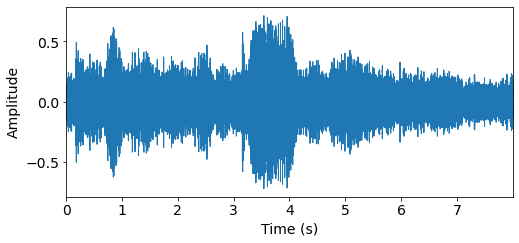

In [5]:
# Plot waveform using librosa function waveplot()
# Note: librosa uses a wrapper on matplotlib to display charts
# X-axis in seconds
fig, ax = plt.subplots(figsize=(8, 3.5))
librosa.display.waveplot(x, sr, x_axis='s')
plt.ylabel('Amplitude')
plt.show()

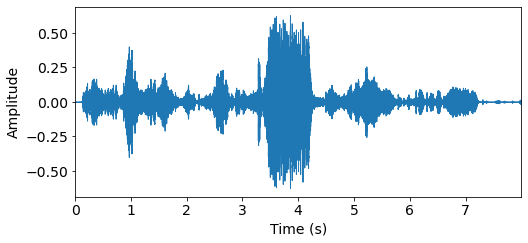

In [6]:
fig, ax = plt.subplots(figsize=(8, 3.5))
librosa.display.waveplot(y, sr, x_axis='s')
plt.ylabel('Amplitude')
plt.show()

In [7]:
# Plot waveform using matplotlib directly and play file

def print_plot_play(amplitudes, sampling_rate, title=''):
    """1. Prints information about an audio signal, 2. plots the waveform, and 3. Creates player
    Args: 
        amplitudes: Input signal amplitudes
        sampling_rate: Sampling rate of input signal    
        text: Text to print
    """
    plt.figure(figsize=(8, 3.5))
    plt.plot(amplitudes, color='lightblue')
    plt.xlim([0, amplitudes.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=amplitudes, rate=sampling_rate))

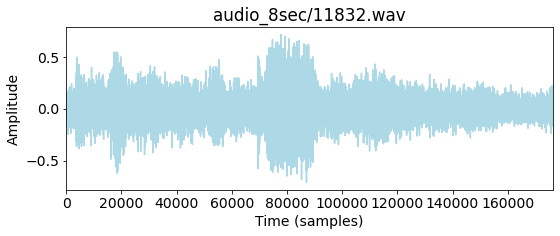

In [72]:
print_plot_play(amplitudes=x, sampling_rate=sr, title=audio_file)

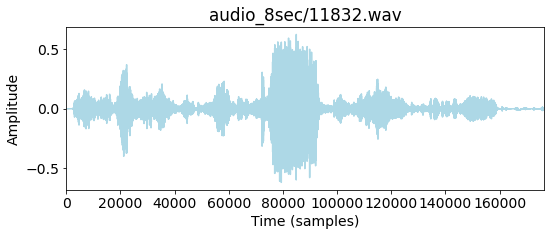

In [8]:
print_plot_play(amplitudes=y, sampling_rate=sr, title=audio_file)

### 5. Waveform in frequency and time domain - Spectrograms

### 5.1 Short Fourier Transform: Time Domain --> Frequency Domain
  
https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft
    
#### librosa stft default parameter values:
sampling rate: sr = 22,050 Hz  
snippets per frame: n_fft = 2,048  
hop length (frame increment) = 512  
  
The stft function in librosa is Discrete Fourier Transform as its input is a digitial waveform.  
The output output of the stft function is a complex number than indicates spectral magnitude and phase.  
  
We are only interested in the magnitude and not the phase. We can extract this information from the complex number output by taking the absolute value with np.abs(). 
The absolute value will actually give us the square of the spectral magnitude.


In [9]:
### Select parameters for fourier transforms below
# Define snippets per frame. librosa sets this to 2048 by default.
n_fft = 2048
# Define hop length. librosa sets this to 512 by default
hop_length = 512

In [10]:
###  Calculate spectrogram
o_S = np.abs(librosa.stft(x, n_fft = n_fft, hop_length=hop_length))
S = np.abs(librosa.stft(y, n_fft = n_fft, hop_length=hop_length))

print(f"The shape of the sftf array is {S.shape}")
print(f"The number of rows in the sftf array, 'D' is '(1 + n_fft/2)=(1 + {n_fft}/2)'")
# The frame length in seconds is the frame size / sampling rate
print(f"The frame size of the sftf is 'snippets per frame'/'sample rate'={n_fft/sr:.4f} sec")
# The hop length in seconds is the hop length / sampling rate
print(f"The hop length of the sftf is 'hop length'/'sample rate'={hop_length/sr:.4f} sec")
# The max value of the sftf (that is display in a color hue on a spectogram)
print(f"The max value from the sftf is {max([max(item) for item in S]):.2f}")

The shape of the sftf array is (1025, 345)
The number of rows in the sftf array, 'D' is '(1 + n_fft/2)=(1 + 2048/2)'
The frame size of the sftf is 'snippets per frame'/'sample rate'=0.0929 sec
The hop length of the sftf is 'hop length'/'sample rate'=0.0232 sec
The max value from the sftf is 63.06


### 5.2 Spectrogram - Linear Axes and Linear Output

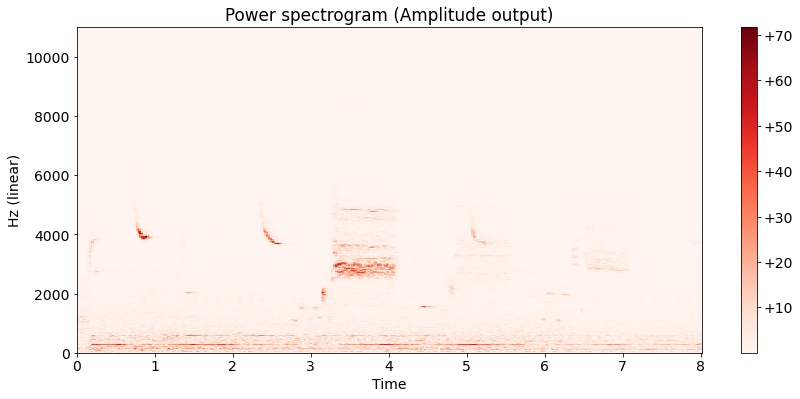

In [11]:
# Plot spectorgram with linear axes and linear output. Note that the linear y axis here is same as hz.
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(o_S, y_axis='linear', x_axis='time', ax=ax, cmap='Reds')
ax.set_title('Power spectrogram (Amplitude output)')
ax.set_ylabel('Hz (linear)')
fig.colorbar(img, ax=ax, format="%+2.0f")
plt.show()

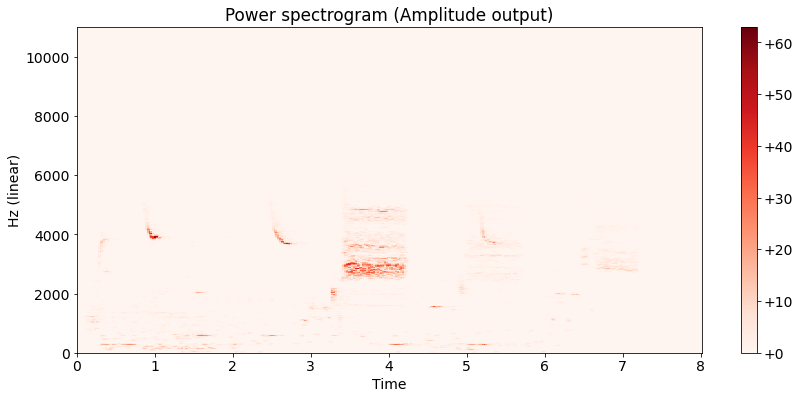

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(S, y_axis='linear', x_axis='time', ax=ax, cmap='Reds')
ax.set_title('Power spectrogram (Amplitude output)')
ax.set_ylabel('Hz (linear)')
fig.colorbar(img, ax=ax, format="%+2.0f")
plt.show()

### 5.3 Spectrogram - Linear Axes & Decibel output

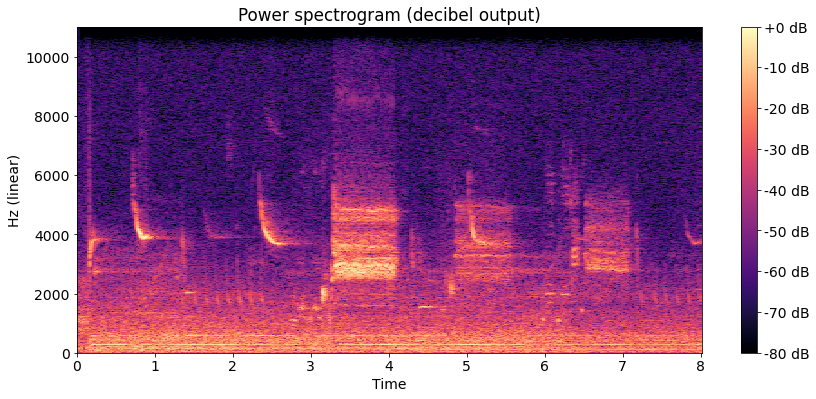

In [14]:
# Calculate decibels of amplitude. Use max amplitude with a reference of 0 dB.
o_S_db = librosa.amplitude_to_db(o_S, ref=np.max)

# Plot spectrogram with linear axes and decibel output. 
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(o_S_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Power spectrogram (decibel output)')
ax.set_ylabel('Hz (linear)')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

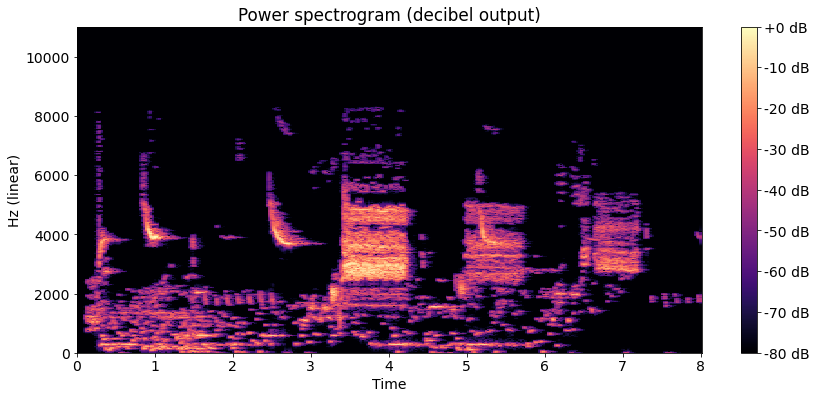

In [15]:
S_db = librosa.amplitude_to_db(S, ref=np.max)

# Plot spectrogram with linear axes and decibel output. 
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(S_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Power spectrogram (decibel output)')
ax.set_ylabel('Hz (linear)')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

### 5.4 Spectrogram - Linear x-axis, Log y-axis, Decibel output

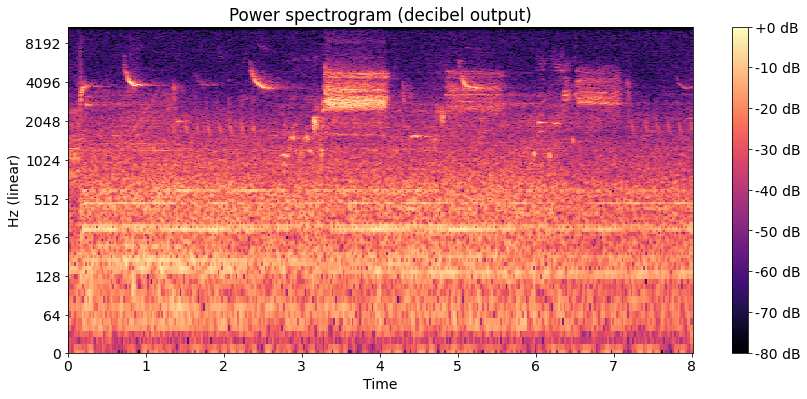

In [16]:
# Plot spectrogram with linear axes and decibel output. 
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(o_S_db, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram (decibel output)')
ax.set_ylabel('Hz (linear)')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

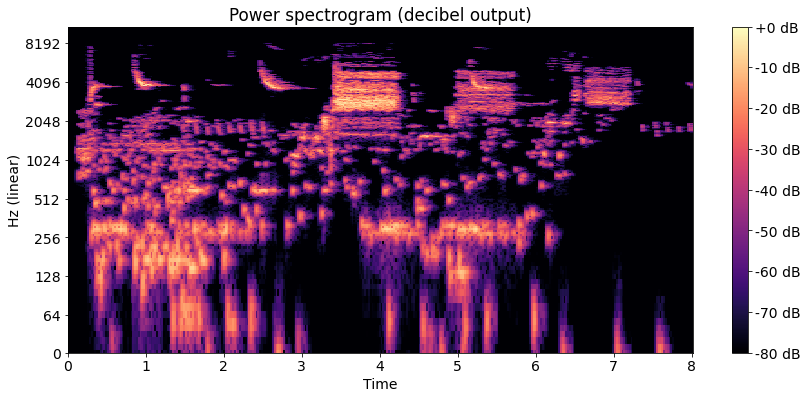

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram (decibel output)')
ax.set_ylabel('Hz (linear)')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

### 5.5 Mel Spectrograms  - Linear x-axis, Mel y-axis, Decibel output
https://librosa.org/doc/0.8.0/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram

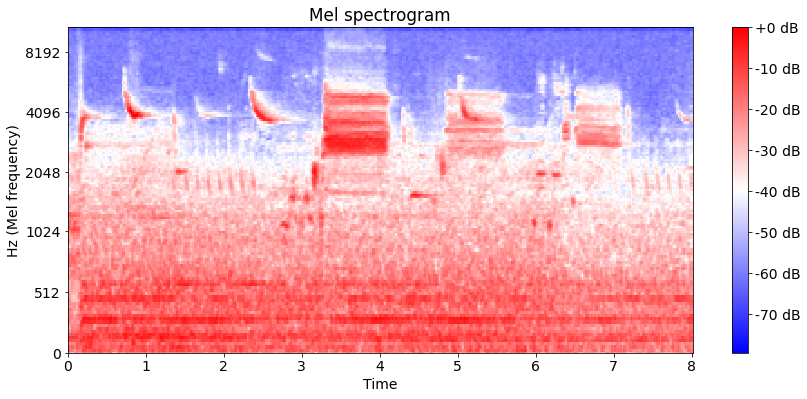

In [18]:
o_M = librosa.feature.melspectrogram(y=x, sr=sr, n_fft = n_fft, hop_length=hop_length)
o_M_db = librosa.power_to_db(o_M, ref=np.max)

fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(o_M_db, y_axis='mel', x_axis='time', sr=sr, ax=ax, cmap='bwr')
ax.set(title='Mel spectrogram')
ax.set_ylabel('Hz (Mel frequency)')
fig.colorbar(img, ax=ax, format="%+2.f dB")
# change font size for x axis
plt.show()

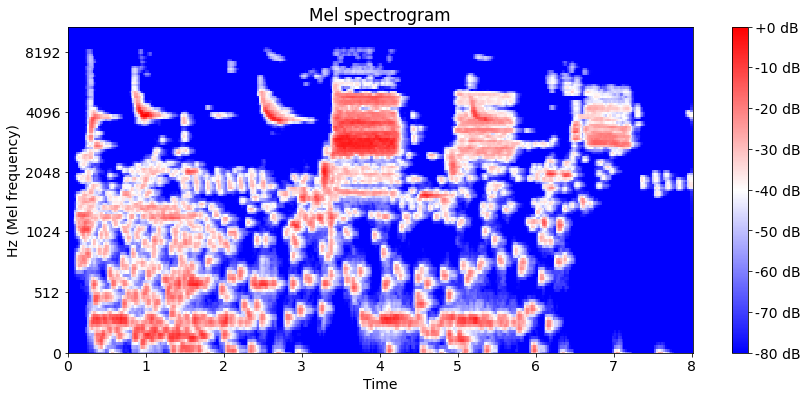

In [19]:
M = librosa.feature.melspectrogram(y=y, sr=sr, n_fft = n_fft, hop_length=hop_length)
M_db = librosa.power_to_db(M, ref=np.max)

fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', sr=sr, ax=ax, cmap='bwr')
ax.set(title='Mel spectrogram')
ax.set_ylabel('Hz (Mel frequency)')
fig.colorbar(img, ax=ax, format="%+2.f dB")
# change font size for x axis
plt.show()

In [29]:
sizes = np.shape(M_db)
height = float(sizes[0])
width = float(sizes[1])
fig = plt.figure()
fig.set_size_inches(width/height, 1, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', sr=sr, ax=ax, cmap='bwr')
# plt.savefig(fn, dpi = height) 
# plt.close()


# img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', sr=sr, ax=ax, cmap='bwr')
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
plt.savefig(f'images/11832.jpg', dpi=height)
plt.savefig(f'images/11832.png')
plt.close()

### 5.6 Constant Q Transform

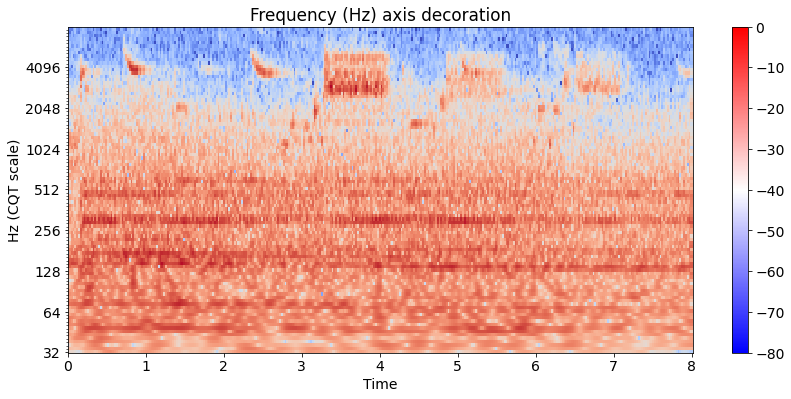

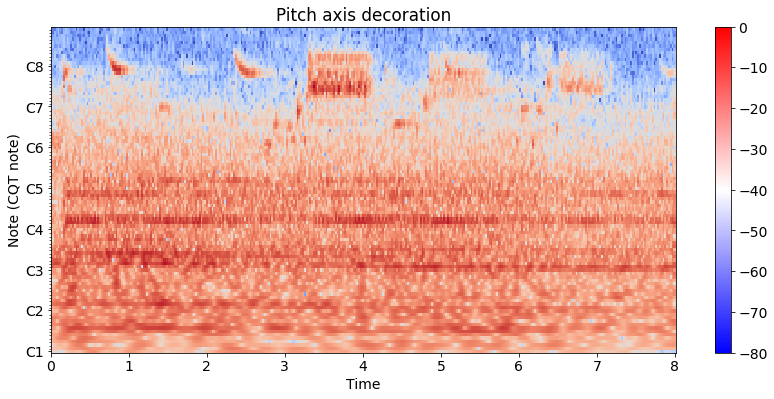

In [86]:
o_C = librosa.cqt(y=x, sr=sr, hop_length=hop_length, n_bins=96)
o_C_db = librosa.amplitude_to_db(np.abs(o_C), ref=np.max)

fig, ax = plt.subplots(figsize=(14, 6))
librosa.display.specshow(o_C_db, y_axis='cqt_hz', x_axis='time', ax=ax, cmap='coolwarm')
ax.set(title='Frequency (Hz) axis decoration')
ax.set_ylabel('Hz (CQT scale)')
fig.colorbar(img, ax=ax)

fig, ax = plt.subplots(figsize=(14, 6))
librosa.display.specshow(o_C_db, y_axis='cqt_note', x_axis='time', ax=ax, cmap='coolwarm')
ax.set(title='Pitch axis decoration')
ax.set_ylabel('Note (CQT note)')
fig.colorbar(img, ax=ax)

plt.show()

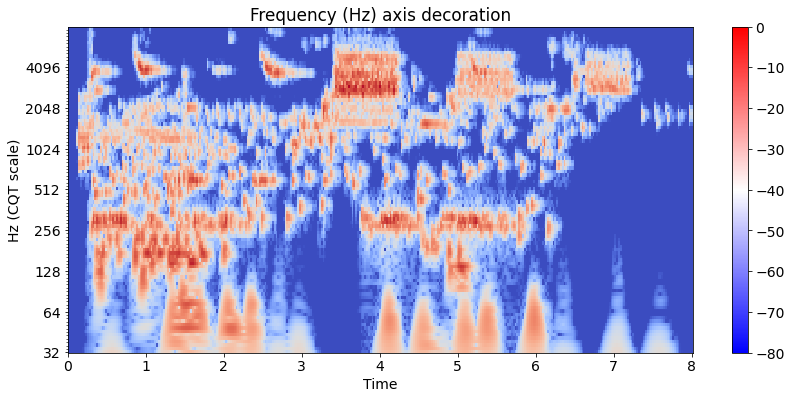

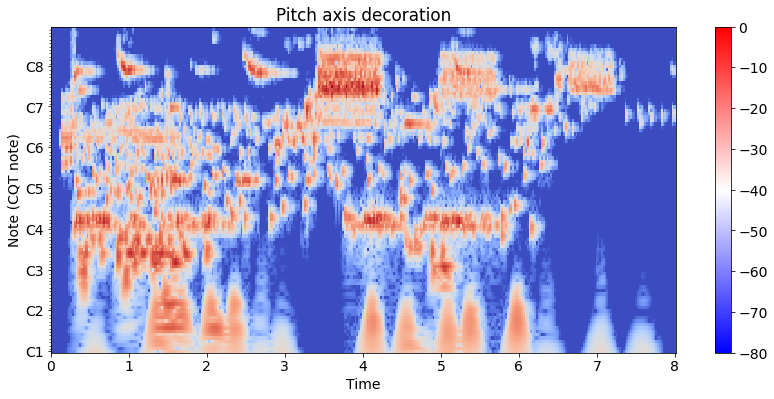

In [87]:
C = librosa.cqt(y=y, sr=sr, hop_length=hop_length, n_bins=96)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)

fig, ax = plt.subplots(figsize=(14, 6))
librosa.display.specshow(C_db, y_axis='cqt_hz', x_axis='time', ax=ax, cmap='coolwarm')
ax.set(title='Frequency (Hz) axis decoration')
ax.set_ylabel('Hz (CQT scale)')
fig.colorbar(img, ax=ax)

fig, ax = plt.subplots(figsize=(14, 6))
librosa.display.specshow(C_db, y_axis='cqt_note', x_axis='time', ax=ax, cmap='coolwarm')
ax.set(title='Pitch axis decoration')
ax.set_ylabel('Note (CQT note)')
fig.colorbar(img, ax=ax)

plt.show()

### 5.7 Chromagram

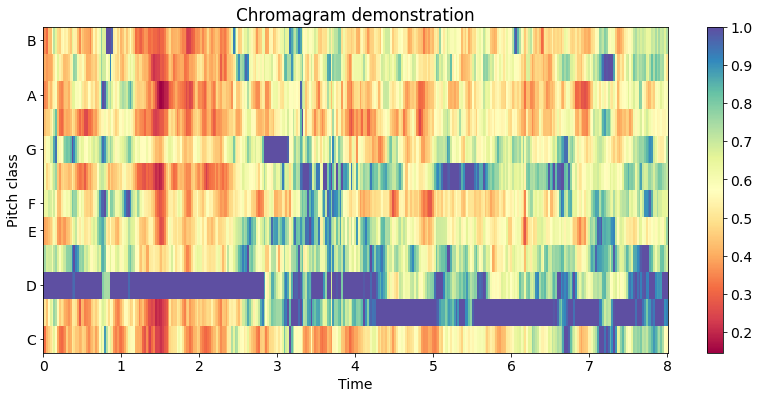

In [89]:
o_chroma = librosa.feature.chroma_cqt(y=x, sr=sr, hop_length=hop_length)
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(o_chroma, y_axis='chroma', x_axis='time', ax=ax, cmap='Spectral')
ax.set(title='Chromagram demonstration')
fig.colorbar(img, ax=ax)

plt.show()

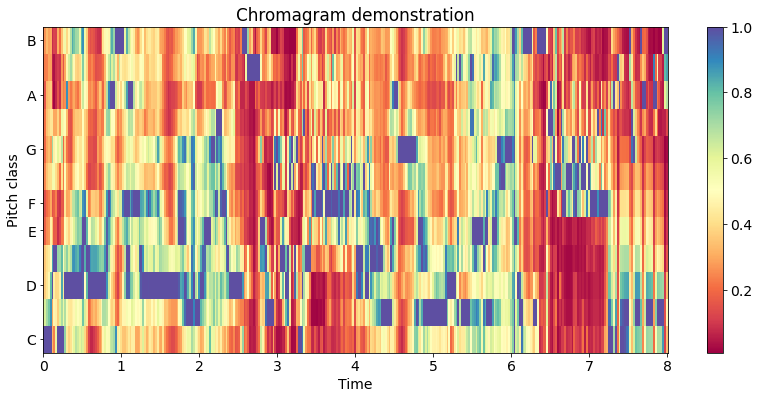

In [90]:
chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
fig, ax = plt.subplots(figsize=(14, 6))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax, cmap='Spectral')
ax.set(title='Chromagram demonstration')
fig.colorbar(img, ax=ax)

plt.show()

**Note how in the audio snippet above the clip is centered around C sharp.**

### 5.8 Example of plotting several of the above charts together

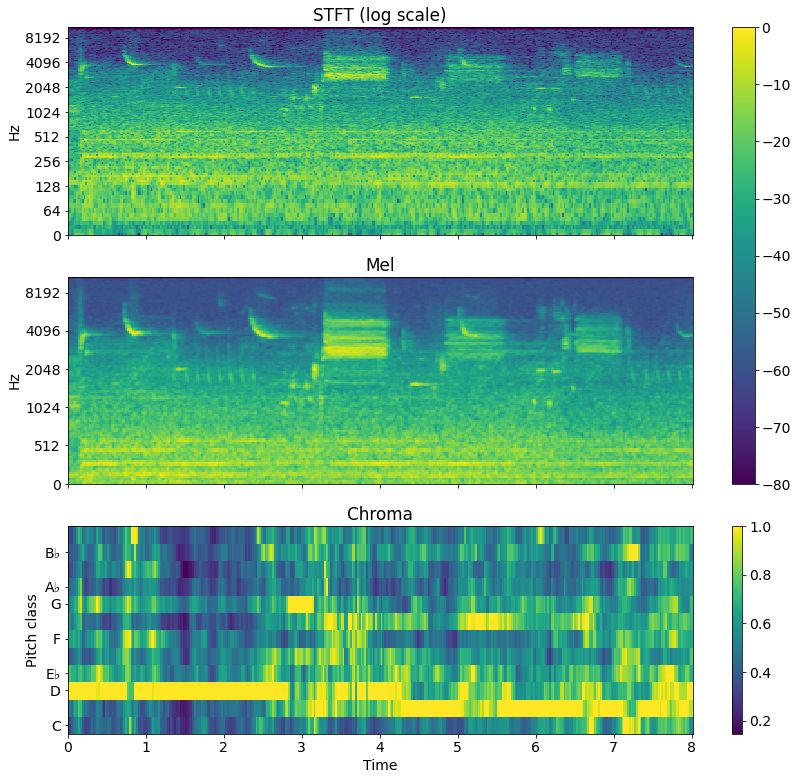

In [92]:
# Choose colormap
color_map = 'viridis'

# Construct a subplot grid with 3 rows and 1 column, sharing the x-axis)
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 13))

# On the first subplot, show the original spectrogram
img1 = librosa.display.specshow(o_S_db, x_axis='time', y_axis='log', ax=ax[0], cmap=color_map)
ax[0].set(title='STFT (log scale)')

# On the second subplot, show the mel spectrogram
img2 = librosa.display.specshow(o_M_db, x_axis='time', y_axis='mel', ax=ax[1], cmap=color_map)
ax[1].set(title='Mel')

# On the third subplot, show the chroma features
img3 = librosa.display.specshow(o_chroma, x_axis='time', y_axis='chroma',
                                key='Eb:maj', ax=ax[2], cmap=color_map)
ax[2].set(title='Chroma')

# To eliminate redundant axis labels, we'll use "label_outer" on all subplots:
for ax_i in ax:
    ax_i.label_outer()

# And we can share colorbars:
fig.colorbar(img1, ax=[ax[0], ax[1]])

# Or have individual colorbars:
fig.colorbar(img3, ax=[ax[2]])

# We can then even do fancy things like zoom into a particular time and frequency
# region.  Since the axes are shared, this will apply to all three subplots at once.
# ax[0].set(xlim=[1, 5])  # Zoom to seconds 1-5

plt.show()

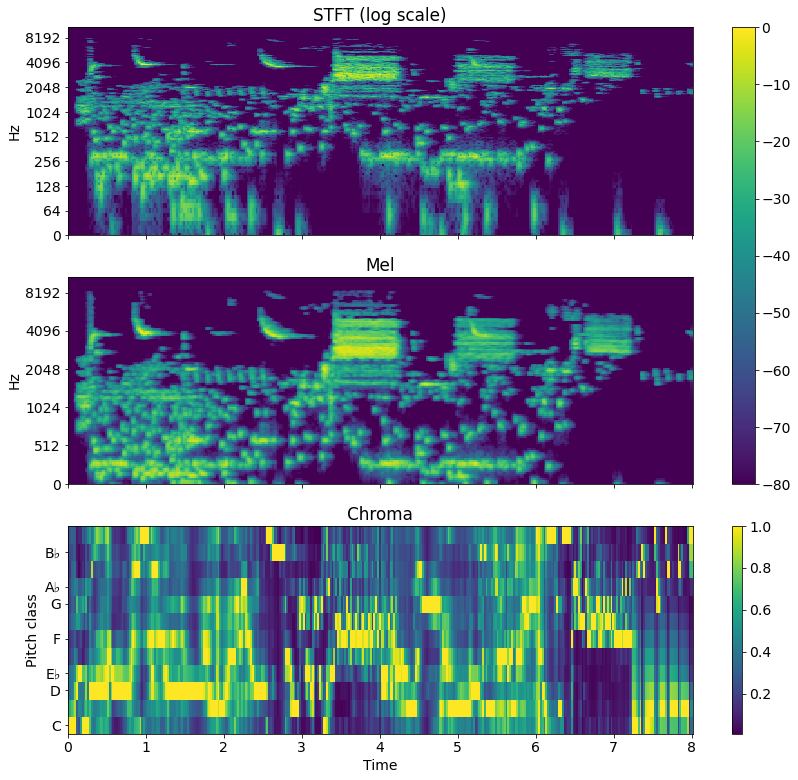

In [91]:
# Choose colormap
color_map = 'viridis'

# Construct a subplot grid with 3 rows and 1 column, sharing the x-axis)
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 13))

# On the first subplot, show the original spectrogram
img1 = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0], cmap=color_map)
ax[0].set(title='STFT (log scale)')

# On the second subplot, show the mel spectrogram
img2 = librosa.display.specshow(M_db, x_axis='time', y_axis='mel', ax=ax[1], cmap=color_map)
ax[1].set(title='Mel')

# On the third subplot, show the chroma features
img3 = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma',
                                key='Eb:maj', ax=ax[2], cmap=color_map)
ax[2].set(title='Chroma')

# To eliminate redundant axis labels, we'll use "label_outer" on all subplots:
for ax_i in ax:
    ax_i.label_outer()

# And we can share colorbars:
fig.colorbar(img1, ax=[ax[0], ax[1]])

# Or have individual colorbars:
fig.colorbar(img3, ax=[ax[2]])

# We can then even do fancy things like zoom into a particular time and frequency
# region.  Since the axes are shared, this will apply to all three subplots at once.
# ax[0].set(xlim=[1, 5])  # Zoom to seconds 1-5

plt.show()

### 6. Spectral Novelty and Onset Detection
 
https://musicinformationretrieval.com/novelty_functions.html  
https://musicinformationretrieval.com/onset_detection.html  
https://librosa.org/doc/main/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect 

[0.13931973 0.30185941 0.55727891 0.71981859 0.85913832 1.13777778
 1.34675737 1.50929705 1.67183673 1.81115646 2.08979592 2.22911565
 2.36843537 2.5077551  2.80961451 2.90249433 2.99537415 3.06503401
 3.27401361 3.41333333 3.57587302 3.78485261 4.06349206 4.29569161
 4.5046712  4.87619048 5.0155102  5.34058957 5.54956916 5.80498866
 5.96752834 6.08362812 6.17650794 6.31582766 6.38548753 6.47836735
 6.66412698 6.82666667 7.38394558 7.54648526 7.70902494 7.84834467
 7.9876644 ]


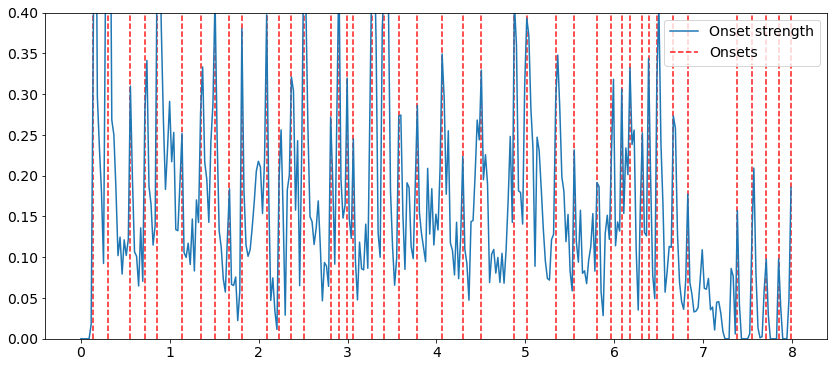

In [93]:
# librosa.onset.onset_strength computes a novelty function using spectral flux.
spectral_novelty = librosa.onset.onset_strength(y, sr=sr)
frames = np.arange(len(spectral_novelty))
t = librosa.frames_to_time(frames, sr=sr)

onset_frames = librosa.onset.onset_detect(y=y, sr=sr, onset_envelope=spectral_novelty , hop_length=hop_length)
onset_times = librosa.frames_to_time(onset_frames)
print(onset_times)

# S = np.abs(librosa.stft(y, n_fft = n_fft, hop_length=hop_length))


fig, ax = plt.subplots(figsize=(14, 6))

# librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])

# ax[0].set(title='Power spectrogram')

# ax[0].label_outer()

ax.plot(t, spectral_novelty, label='Onset strength')

ax.vlines(t[onset_frames], 0, spectral_novelty.max(), color='r', alpha=0.9,
          linestyle='--', label='Onsets')

ax.set(ylim=[0, 0.4])
ax.legend()
plt.show()

### 7. xxx

In [46]:


number_mfcc = 8
df = pd.DataFrame(columns = ['mfcc_avg' + str(item+1) for item in list(range(number_mfcc))] +
                            ['mfcc_std' + str(item+1) for item in list(range(number_mfcc))], 
                   index = audio_files)
        
        
        
for audio_file in audio_files:
    
    import_sample_rate = 22050
    y, sr = librosa.load(audio_file, sr=import_sample_rate, mono=True)
#     yt, index = librosa.effects.trim(y)

#     print_plot_play(amplitudes=y[:66150], sampling_rate=sr, title=audio_file)
    mfccs = librosa.feature.mfcc(y=y[:66150], sr=sr, n_mfcc=number_mfcc, hop_length=2048)
    #print(mfccs)
    
    mfcc_means = [np.mean(item) for item in mfccs]
    mfcc_stds = [np.std(item) for item in mfccs]
    print("mfcc means:", mfcc_means, "\nmfcc std deviations:", mfcc_stds)
    df.loc[audio_file] = mfcc_means + mfcc_stds
  
    print(f"{audio_file} processed.\n")
    
#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(mfccs, x_axis='time')
#     plt.colorbar()
#     plt.title(audio_file)
#     plt.tight_layout()
    
    
    
    
     



mfcc means: [-664.355, 122.87402, -94.64589, 11.713354, 14.125656, -8.451888, 29.96346, -12.378973] 
mfcc std deviations: [85.06985, 45.331238, 54.24941, 43.95663, 30.901651, 32.13092, 30.454477, 33.65532]
audio_8sec\107449.wav processed.

mfcc means: [-687.6366, -46.58822, -27.287243, 46.465622, -16.965294, -4.585976, 1.6901634, 5.917141] 
mfcc std deviations: [62.805573, 54.82026, 33.359505, 35.268948, 30.323996, 24.1064, 24.051851, 20.80597]
audio_8sec\107456.wav processed.

mfcc means: [-677.2799, 9.974558, -22.387735, 12.699582, 21.256224, 19.98599, 7.803965, 9.065239] 
mfcc std deviations: [86.4858, 17.045008, 85.62371, 16.689238, 27.221437, 20.749546, 16.187906, 18.834044]
audio_8sec\107457.wav processed.

mfcc means: [-684.4069, -28.121246, -38.52296, 95.338036, 10.679529, 2.1383755, 18.99519, 18.829525] 
mfcc std deviations: [96.56176, 56.763763, 70.30185, 84.45092, 41.15521, 39.229282, 18.636118, 19.630974]
audio_8sec\107458.wav processed.

mfcc means: [-693.0198, -35.308567,

mfcc means: [-727.86224, -58.01436, -3.1378555, 99.99865, -51.744694, 27.957756, 17.696684, -8.35585] 
mfcc std deviations: [76.4747, 77.021904, 52.02532, 72.0604, 63.232445, 42.474545, 28.470007, 21.477629]
audio_8sec\31066.wav processed.

mfcc means: [-604.7325, -54.40852, -9.303505, 25.578444, 4.4770775, -0.7966947, -29.804977, 47.180374] 
mfcc std deviations: [44.030426, 54.979023, 48.44528, 28.558256, 43.386337, 50.20681, 40.69897, 37.74205]
audio_8sec\31114.wav processed.

mfcc means: [-601.5728, -42.305653, 19.501968, 57.649883, 12.28579, 47.605152, -11.758452, 62.734848] 
mfcc std deviations: [61.876926, 50.800957, 26.036434, 35.308334, 26.978516, 37.95354, 36.348373, 45.658302]
audio_8sec\31115.wav processed.

mfcc means: [-675.4465, -34.26853, 16.550758, 24.079678, -3.8020399, 39.464146, -22.86721, 34.39081] 
mfcc std deviations: [54.76543, 44.411186, 37.723045, 26.269793, 37.436687, 40.040028, 41.98978, 27.758093]
audio_8sec\31116.wav processed.

mfcc means: [-663.53925, -25

mfcc means: [-964.52075, -20.157148, -16.443233, 22.21157, -6.0690036, -13.048649, 13.518261, 1.8834947] 
mfcc std deviations: [93.12005, 19.43639, 21.564589, 32.287575, 17.930742, 22.1961, 21.535028, 18.42818]
audio_8sec\323252.wav processed.

mfcc means: [-893.9425, -38.970673, -27.504417, 34.757286, -10.526125, 10.74826, -17.03613, 7.851204] 
mfcc std deviations: [109.74832, 76.30836, 35.31238, 59.10359, 33.681904, 13.878921, 19.488857, 26.324574]
audio_8sec\323255.wav processed.

mfcc means: [-869.8276, -29.067255, -21.603134, 24.712255, -1.247331, 2.7041178, -20.658266, 5.4973826] 
mfcc std deviations: [49.938736, 41.884132, 61.60717, 34.14098, 48.60034, 41.759453, 31.601686, 31.09322]
audio_8sec\323258.wav processed.

mfcc means: [-945.99713, -43.715393, 5.561532, 21.422337, -25.446543, 16.778307, -4.557679, 2.8793228] 
mfcc std deviations: [97.198074, 68.54849, 15.3643265, 41.40848, 41.978474, 26.119884, 18.434027, 19.388042]
audio_8sec\324512.wav processed.

mfcc means: [-566.2

mfcc means: [-703.753, -67.14489, -58.76374, 116.63773, -29.835873, -12.245497, 15.289086, -1.111716] 
mfcc std deviations: [95.78427, 57.883064, 54.669434, 94.0432, 47.149536, 25.13904, 39.499584, 23.057463]
audio_8sec\404499.wav processed.

mfcc means: [-685.6451, -20.527048, -46.75774, 27.871058, 4.6669397, -8.270565, -1.6327883, 9.791437] 
mfcc std deviations: [62.344006, 40.68018, 46.724236, 59.789463, 24.288836, 28.318516, 18.243898, 26.464594]
audio_8sec\408979.wav processed.

mfcc means: [-614.72485, -23.417711, -92.75156, 15.133534, 14.514867, 6.032043, 3.320042, -2.8259163] 
mfcc std deviations: [133.38354, 53.264606, 90.28201, 47.546597, 28.98357, 26.866228, 20.71802, 20.872267]
audio_8sec\408980.wav processed.

mfcc means: [-695.681, -33.63885, -83.14027, 38.65586, 16.039253, -5.360193, -7.6053705, 4.1692147] 
mfcc std deviations: [100.9556, 60.041763, 74.00646, 74.9085, 34.30658, 25.470367, 22.776525, 25.155073]
audio_8sec\408982.wav processed.

mfcc means: [-764.64185, -4

mfcc means: [-793.0396, -29.944864, -42.373684, 13.72278, -9.521758, 12.668963, -13.548429, 3.2178562] 
mfcc std deviations: [149.8082, 55.41669, 73.832, 25.491125, 27.953165, 22.863344, 22.885563, 17.413015]
audio_8sec\49864.wav processed.

mfcc means: [-827.1071, 3.5761998, 8.1149025, 52.547195, -3.9428513, 5.410512, 19.826887, 45.13126] 
mfcc std deviations: [53.27374, 44.503876, 34.08197, 42.27008, 43.41685, 35.211277, 28.105593, 25.809313]
audio_8sec\533370.wav processed.

mfcc means: [-829.17285, 18.820845, -18.24172, -65.62439, -48.714928, 1.0035762, 31.27336, 36.027035] 
mfcc std deviations: [117.83527, 42.01925, 22.2972, 32.639236, 17.584934, 22.311197, 18.570759, 16.19648]
audio_8sec\554554.wav processed.

mfcc means: [-623.5272, -36.32225, -80.85148, 61.124, 16.427597, -28.603786, 3.623009, 8.331062] 
mfcc std deviations: [89.844154, 45.482967, 69.5267, 53.47317, 32.16863, 20.405167, 22.253, 19.50268]
audio_8sec\55548.wav processed.

mfcc means: [-573.68634, -44.82681, -50.2

In [47]:
df

mfcc_avg1 mfcc_avg2 mfcc_avg3 mfcc_avg4 mfcc_avg5  \
audio_8sec\107449.wav  -664.355   122.874  -94.6459   11.7134   14.1257   
audio_8sec\107456.wav  -687.637  -46.5882  -27.2872   46.4656  -16.9653   
audio_8sec\107457.wav   -677.28   9.97456  -22.3877   12.6996   21.2562   
audio_8sec\107458.wav  -684.407  -28.1212   -38.523    95.338   10.6795   
audio_8sec\107470.wav   -693.02  -35.3086  -20.5463   48.4832  -28.4173   
...                         ...       ...       ...       ...       ...   
audio_8sec\646125.wav  -795.015  -7.82088  -40.0975   22.5079   27.1435   
audio_8sec\646210.wav   -730.66  -16.9584   4.34235   16.7361  -4.50911   
audio_8sec\83414.wav   -546.677    11.589   17.3331   22.1721   12.9991   
audio_8sec\83853.wav   -740.321   28.5513  -34.2211   7.25262  -19.7467   
audio_8sec\98722.wav   -663.176  -56.9793  -56.5108   45.0224  -9.86701   

                      mfcc_avg6 mfcc_avg7 mfcc_avg8 mfcc_std1 mfcc_std2  \
audio_8sec\107449.wav  -8.45189   29.9635   -12.379   85.0698   45.3312   
audio_8sec\107456.wav  -4.58598   1.69016   5.91714   62.8056   54.8203   
audio_8sec\107457.wav    19.986   7.80397   9.06524   86.4858    17.045   
audio_8sec\107458.wav   2.13838   18.9952   18.8295   96.5618   56.7638   
audio_8sec\107470.wav  -4.83176   19.0893  -8.82271   87.9056   54.0566   
...                         ...       ...       ...       ...       ...   
audio_8sec\646125.wav  -18.6677   2.23634   28.2853   58.3581   26.7569   
audio_8sec\646210.wav   8.87145   5.06654   4.94215   71.4587   54.2718   
audio_8sec\83414.wav    18.8167   16.3172   17.9155   35.0664   25.6512   
audio_8sec\83853.wav   -39.1175  -18.7957  -3.17046   133.867   32.4874   
audio_8sec\98722.wav    10.4675  -8.36467 -0.108088   130.687   79.6294   

                      mfcc_std3 mfcc_std4 mfcc_std5 mfcc_std6 mfcc_std7  \
audio_8sec\107449.wav   54.2494   43.9566   30.9017   32.1309   30.4545   
audio_8sec\107456.wav   33.3595   35.2689    30.324   24.1064   24.0519   
audio_8sec\107457.wav   85.6237   16.6892   27.2214   20.7495   16.1879   
audio_8sec\107458.wav   70.3018   84.4509   41.1552   39.2293   18.6361   
audio_8sec\107470.wav   33.1432   63.9139   45.8097   31.1417   27.1568   
...                         ...       ...       ...       ...       ...   
audio_8sec\646125.wav   53.1972   35.3077   30.0424   38.6207   24.8667   
audio_8sec\646210.wav   24.3165   23.8426   26.6964   17.9598   10.0887   
audio_8sec\83414.wav    12.5028   29.1971   15.2549   13.3988   11.4501   
audio_8sec\83853.wav    64.1998   37.8778   29.9768   46.8721   24.3116   
audio_8sec\98722.wav    67.7619    70.035     16.94    16.418   18.9689   

                      mfcc_std8  
audio_8sec\107449.wav   33.6553  
audio_8sec\107456.wav    20.806  
audio_8sec\107457.wav    18.834  
audio_8sec\107458.wav    19.631  
audio_8sec\107470.wav   20.9233  
...                         ...  
audio_8sec\646125.wav   35.8094  
audio_8sec\646210.wav    11.242  
audio_8sec\83414.wav    11.8177  
audio_8sec\83853.wav    25.0587  
audio_8sec\98722.wav    12.4982  

[176 rows x 16 columns]